In [102]:
from joblib import dump

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score

from pandas_profiling import ProfileReport

import shap

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### Loading the data

In [3]:
churn_df = pd.read_csv('./data/churn_train_val.csv')
test_df = pd.read_csv('./data/churn_test_labeled.csv')

In [4]:
churn_df.shape

(9000, 11)

In [5]:
test_df.shape

(1000, 11)

In [6]:
churn_df.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
churn                 int64
dtype: object

In [7]:
churn_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,781,Spain,Male,35,1,0.00,2,0,0,42117.90,0
1,701,Spain,Female,21,9,0.00,2,1,1,26327.42,0
2,685,Spain,Female,25,10,128509.63,1,1,0,121562.33,0
3,680,France,Male,34,3,143292.95,1,1,0,66526.01,0
4,756,Germany,Female,34,2,148200.72,1,0,0,194584.48,0


In [8]:
test_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,713,Spain,Female,48,1,163760.82,1,0,0,157381.14,1
1,502,France,Male,30,4,0.00,2,1,1,66263.87,0
2,817,Germany,Male,45,9,101207.75,1,0,0,88211.12,1
3,730,France,Male,39,1,116537.60,1,0,0,145679.60,0
4,576,Spain,Male,52,2,100549.43,2,1,1,16644.16,0


### Profiling the data

In [9]:
profile = ProfileReport(churn_df)

In [10]:
profile.to_notebook_iframe()

### Analyzing features vs. target

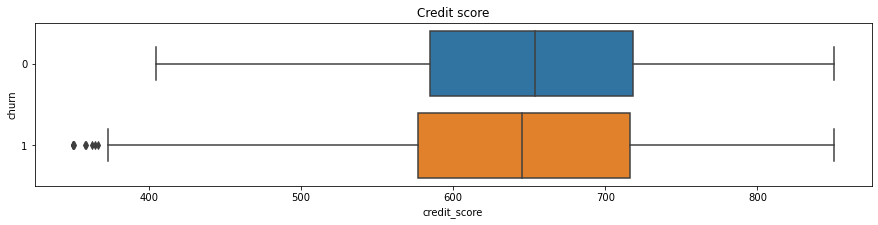

In [11]:
plt.figure(figsize = (15, 3))
sns.boxplot(data = churn_df, x = 'credit_score', y = 'churn', orient = 'h')
plt.title('Credit score')
plt.show()

In [12]:
pd.crosstab(churn_df['churn'], churn_df['country'], normalize = 'columns')

country,France,Germany,Spain
churn,,,
0,0.838083,0.67593,0.831847
1,0.161917,0.32407,0.168153


In [13]:
pd.crosstab(churn_df['churn'], churn_df['gender'], normalize = 'columns')

gender,Female,Male
churn,,
0,0.748541,0.836538
1,0.251459,0.163462


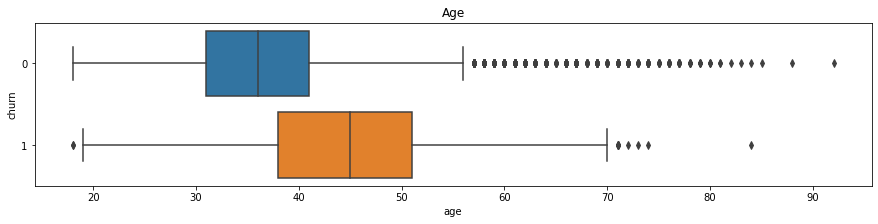

In [14]:
plt.figure(figsize = (15, 3))
sns.boxplot(data = churn_df, x = 'age', y = 'churn', orient = 'h')
plt.title('Age')
plt.show()

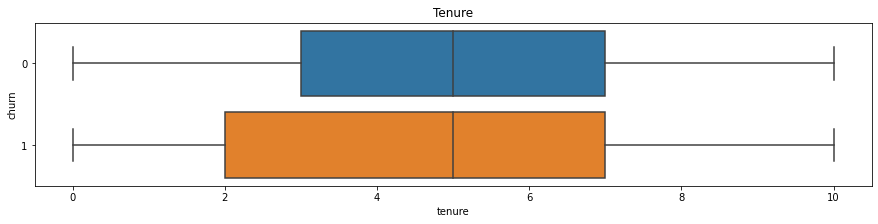

In [15]:
plt.figure(figsize = (15, 3))
sns.boxplot(data = churn_df, x = 'tenure', y = 'churn', orient = 'h')
plt.title('Tenure')
plt.show()

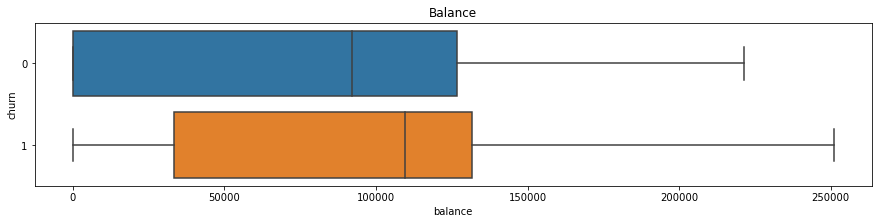

In [16]:
plt.figure(figsize = (15, 3))
sns.boxplot(data = churn_df, x = 'balance', y = 'churn', orient = 'h')
plt.title('Balance')
plt.show()

In [17]:
pd.crosstab(churn_df['churn'], churn_df['products_number'], normalize = 'columns')

products_number,1,2,3,4
churn,,,,
0,0.723349,0.922965,0.167382,0.0
1,0.276651,0.077035,0.832618,1.0


In [18]:
pd.crosstab(churn_df['churn'], churn_df['credit_card'], normalize = 'columns')

credit_card,0,1
churn,,
0,0.79414,0.797255
1,0.20586,0.202745


In [19]:
pd.crosstab(churn_df['churn'], churn_df['active_member'], normalize = 'columns')

active_member,0,1
churn,,
0,0.73243,0.85622
1,0.26757,0.14378


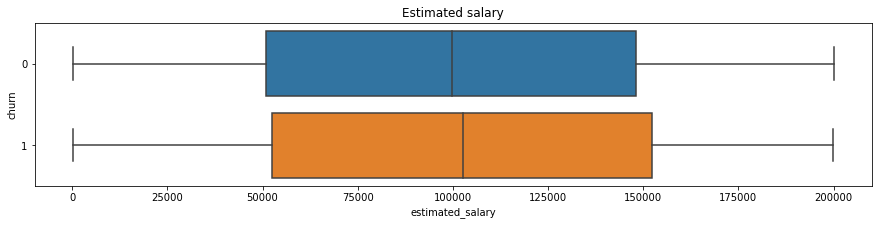

In [20]:
plt.figure(figsize = (15, 3))
sns.boxplot(data = churn_df, x = 'estimated_salary', y = 'churn', orient = 'h')
plt.title('Estimated salary')
plt.show()

### Training a first set of models and selecting the best using F1

In [21]:
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

In [22]:
tree = DecisionTreeClassifier(random_state = 10)

In [23]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'class_weight': ['balanced', None]
}

In [24]:
grid = GridSearchCV(estimator = tree, param_grid = param_grid, scoring = ['precision', 'recall', 'f1'], n_jobs = 1, refit = 'f1', cv = 5, return_train_score = True, verbose = 2)

In [25]:
grid.fit(churn_df[features], churn_df['churn'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .class_weight=balanced, criterion=gini, max_depth=2; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=2; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=2; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=2; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=2; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=3; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=3; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=3; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=3; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=3; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini, max_depth=4; total time=   0.0s
[CV] END .class_weight=balanced, criterion=gini

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10), n_jobs=1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1'], verbose=2)

In [26]:
grid.best_params_

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5}

In [27]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns = {'index': 'result', grid.best_index_: 'value'})
best_results_df = best_results_df.loc[best_results_df['result'].str.contains('split')]
[best_results_df['split'], best_results_df['dataset'], best_results_df['metric']] = zip(*best_results_df['result'].str.split('_'))
best_results_df['dataset'].replace({'test': 'validation'}, inplace = True)
del best_results_df['result']

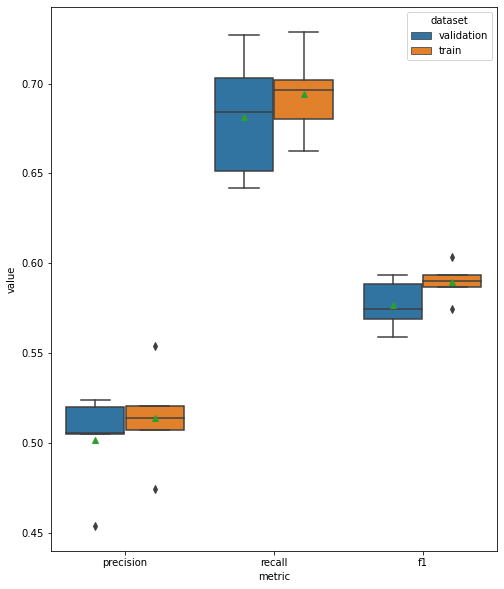

In [28]:
plt.figure(figsize = (8, 10))
sns.boxplot(data = best_results_df, y = 'value', x = 'metric', hue = 'dataset', showmeans = True)
plt.show()

In [29]:
train_val_preds = grid.best_estimator_.predict(churn_df[features])
test_preds = grid.best_estimator_.predict(test_df[features])

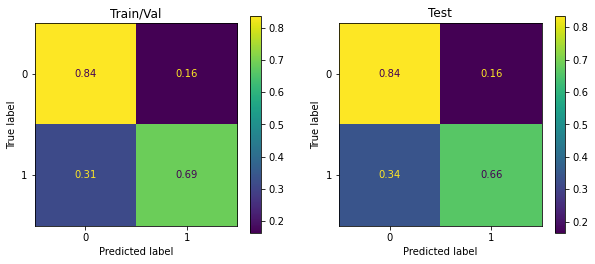

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

train_val_cm = confusion_matrix(churn_df['churn'], train_val_preds, labels = grid.best_estimator_.classes_, normalize = 'true')
train_val_disp = ConfusionMatrixDisplay(confusion_matrix = train_val_cm, display_labels = grid.best_estimator_.classes_)
train_val_disp.plot(ax = axes[0])
axes[0].set_title('Train/Val')

test_cm = confusion_matrix(test_df['churn'], test_preds, labels = grid.best_estimator_.classes_, normalize = 'true')
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = grid.best_estimator_.classes_)
test_disp.plot(ax = axes[1])
axes[1].set_title('Test')

plt.show()

In [31]:
print('Precision:')
print('- Train/Val:', precision_score(churn_df['churn'], train_val_preds))
print('- Test:', precision_score(test_df['churn'], test_preds))
print('\nRecall:')
print('- Train/Val:', recall_score(churn_df['churn'], train_val_preds))
print('- Test:', recall_score(test_df['churn'], test_preds))
print('\nF1:')
print('- Train/Val:', f1_score(churn_df['churn'], train_val_preds))
print('- Test:', f1_score(test_df['churn'], test_preds))

Precision:
- Train/Val: 0.5185643564356436
- Test: 0.5075187969924813

Recall:
- Train/Val: 0.6857610474631751
- Test: 0.6617647058823529

F1:
- Train/Val: 0.5905567300916138
- Test: 0.5744680851063829


### Adding categorical features and training with new algorithms

In [32]:
features2 = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'gender', 'country']

In [33]:
pipeline = Pipeline([
    ('transformer', ColumnTransformer([
        ('ordinal', OrdinalEncoder(), ['gender']),
        ('categorical', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), ['country'])
    ], remainder = 'passthrough')),
    ('poly', 'passthrough'),
    ('normalizer', StandardScaler()),
    ('classifier',  DecisionTreeClassifier())
]) 

In [34]:
param_grid2 = [
    {
        'classifier': [DecisionTreeClassifier(random_state = 20)],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'classifier__class_weight': ['balanced', None]
    },
    {
        'poly': [PolynomialFeatures()],
        'poly__degree': [1, 2, 3, 4],
        'normalizer': [StandardScaler(), MinMaxScaler()],
        'classifier': [LogisticRegression()],
        'classifier__penalty': ['none', 'l1', 'l2'],
        'classifier__C': [0.001, 0.01, 0.1, 1.],
        'classifier__class_weight': ['balanced', None]
    }
]

In [35]:
grid2 = GridSearchCV(estimator = pipeline, param_grid = param_grid2, scoring = ['precision', 'recall', 'f1'], n_jobs = 1, refit = 'f1', cv = 5, return_train_score = True, verbose = 2)

In [36]:
grid2.fit(churn_df[features2], churn_df['churn'])

Fitting 5 folds for each of 228 candidates, totalling 1140 fits
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, 

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3

[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_l

[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScale

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.1s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.1s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.4s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3

[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_l

[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFe

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/met

[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.2s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.2s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.001, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), 

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3

[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_l

[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), 

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.1s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), po

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=Polyn

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3

[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_l

[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatu

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.7s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeature

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.01, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), pol

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3

[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=Po

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=Polynomial

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.1s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_l

[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFe

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.1s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_l

[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.1s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.7s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.2s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), 

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__de

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l1, normalizer=StandardScaler(), poly=Po

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=Polynomial

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=balanced, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFe

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures()

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.7s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=none, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l1, normalizer=StandardScaler(), poly=PolynomialFeatures(), 

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.6s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.8s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__de

/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.2s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=2; total time=   0.3s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.4s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.7s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.5s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=3; total time=   0.7s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.1s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.1s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   1.0s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
320 fits failed out of a total of 1140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fit

[CV] END classifier=LogisticRegression(), classifier__C=1.0, classifier__class_weight=None, classifier__penalty=l2, normalizer=MinMaxScaler(), poly=PolynomialFeatures(), poly__degree=4; total time=   0.9s


/Users/fabiapena/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['gender']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['country'])])),
                                       ('poly', 'passthrough'),
                                       ('normalizer', StandardScaler()),
                                       ('classifier',

In [37]:
grid2.best_params_

{'classifier': LogisticRegression(class_weight='balanced'),
 'classifier__C': 1.0,
 'classifier__class_weight': 'balanced',
 'classifier__penalty': 'l2',
 'normalizer': StandardScaler(),
 'poly': PolynomialFeatures(degree=3),
 'poly__degree': 3}

In [38]:
best_results_df = pd.DataFrame(grid2.cv_results_).iloc[grid2.best_index_].reset_index().rename(columns = {'index': 'result', grid2.best_index_: 'value'})
best_results_df = best_results_df.loc[best_results_df['result'].str.contains('split')]
[best_results_df['split'], best_results_df['dataset'], best_results_df['metric']] = zip(*best_results_df['result'].str.split('_'))
best_results_df['dataset'].replace({'test': 'validation'}, inplace = True)
del best_results_df['result']

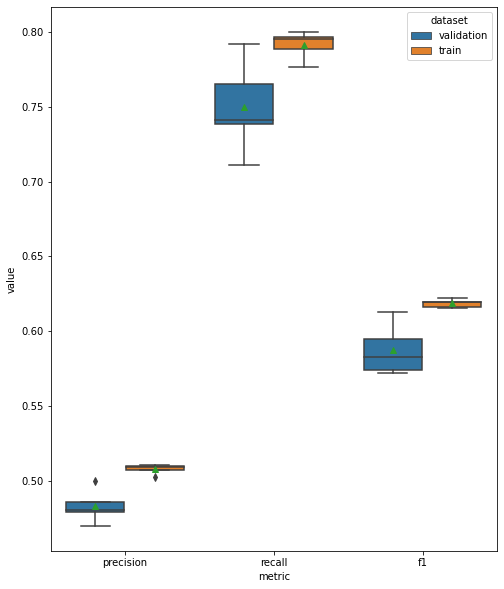

In [39]:
plt.figure(figsize = (8, 10))
sns.boxplot(data = best_results_df, y = 'value', x = 'metric', hue = 'dataset', showmeans = True)
plt.show()

In [40]:
train_val_preds = grid2.best_estimator_.predict(churn_df[features2])
test_preds = grid2.best_estimator_.predict(test_df[features2])

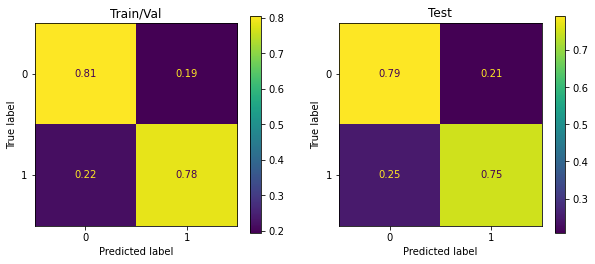

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

train_val_cm = confusion_matrix(churn_df['churn'], train_val_preds, labels = grid2.best_estimator_.classes_, normalize = 'true')
train_val_disp = ConfusionMatrixDisplay(confusion_matrix = train_val_cm, display_labels = grid2.best_estimator_.classes_)
train_val_disp.plot(ax = axes[0])
axes[0].set_title('Train/Val')

test_cm = confusion_matrix(test_df['churn'], test_preds, labels = grid2.best_estimator_.classes_, normalize = 'true')
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = grid2.best_estimator_.classes_)
test_disp.plot(ax = axes[1])
axes[1].set_title('Test')

plt.show()

In [42]:
print('Precision:')
print('- Train/Val:', precision_score(churn_df['churn'], train_val_preds))
print('- Test:', precision_score(test_df['churn'], test_preds))
print('\nRecall:')
print('- Train/Val:', recall_score(churn_df['churn'], train_val_preds))
print('- Test:', recall_score(test_df['churn'], test_preds))
print('\nF1:')
print('- Train/Val:', f1_score(churn_df['churn'], train_val_preds))
print('- Test:', f1_score(test_df['churn'], test_preds))

Precision:
- Train/Val: 0.5092198581560283
- Test: 0.4811320754716981

Recall:
- Train/Val: 0.7834151663938898
- Test: 0.75

F1:
- Train/Val: 0.6172361917042768
- Test: 0.5862068965517241


### Exporting the pipeline

In [43]:
dump(grid2.best_estimator_, './models/churn-v1.0.joblib') 

FileNotFoundError: [Errno 2] No such file or directory: './models/churn-v1.0.joblib'

### Explaining predictions

In [128]:
test_preds_proba = grid.best_estimator_.predict_proba(test_df[features])[:, 1]

In [162]:
test_df['prob'] = test_preds_proba

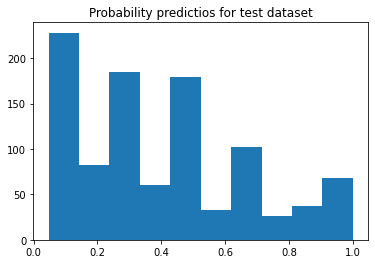

In [163]:
plt.hist(test_preds_proba)
plt.title('Probability predictios for test dataset')
plt.show()

In [164]:
test_df.loc[test_preds_proba < 0.1].head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,prob
1,502,France,Male,30,4,0.0,2,1,1,66263.87,0,0.046717
12,498,France,Female,31,10,0.0,2,1,0,13892.57,0,0.046717
13,474,France,Female,30,9,0.0,2,0,0,63158.22,0,0.046717
25,616,Spain,Male,30,5,0.0,2,0,1,196108.51,0,0.046717
37,536,France,Male,35,8,0.0,2,1,0,64833.28,0,0.046717


In [165]:
test_df.loc[test_preds_proba > 0.9].head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,prob
21,569,Spain,Female,51,3,0.00,3,1,0,75084.96,1,1.000000
30,651,Germany,Female,35,1,163700.78,3,1,1,29583.48,1,1.000000
126,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0.969021
127,633,Germany,Male,58,2,128137.42,2,1,0,147635.33,1,0.956006
148,533,Germany,Female,49,1,102286.60,3,1,0,69409.37,1,0.995106


In [166]:
test_df.loc[(test_preds_proba > 0.47) & (test_preds_proba < 0.53)].head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,prob
4,576,Spain,Male,52,2,100549.43,2,1,1,16644.16,0,0.529263
7,706,Germany,Male,67,1,123276.69,2,1,1,86507.88,1,0.529263
62,717,Germany,Female,64,10,98362.35,2,1,1,21630.21,0,0.529263
72,545,Germany,Male,45,6,93796.42,2,1,1,162321.26,0,0.529263
85,775,France,Male,42,6,133970.22,2,0,1,187839.90,0,0.529263


In [141]:
explainer = shap.Explainer(grid.best_estimator_.predict, test_df[features])
shap_values = explainer(test_df[features])

**Explaining individual predictions:**

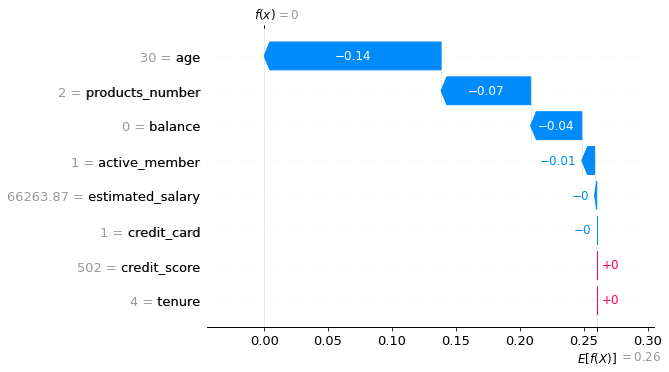

In [159]:
shap.plots.waterfall(shap_values[1])

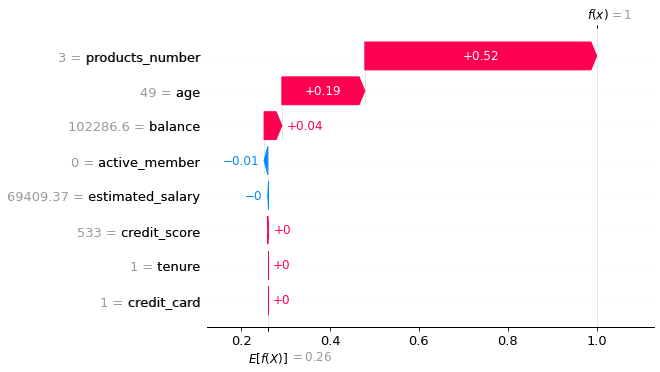

In [158]:
shap.plots.waterfall(shap_values[148])

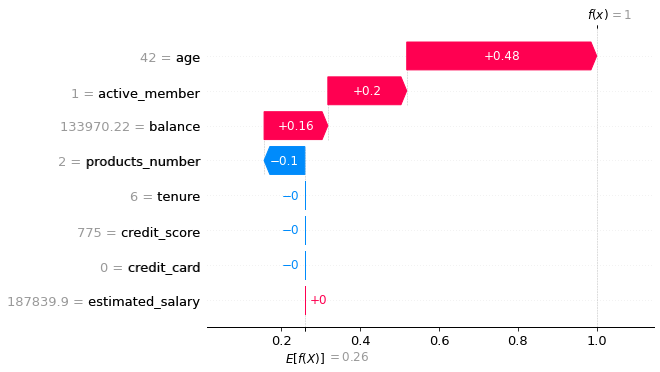

In [157]:
shap.plots.waterfall(shap_values[85])

**Explaining all instances:**

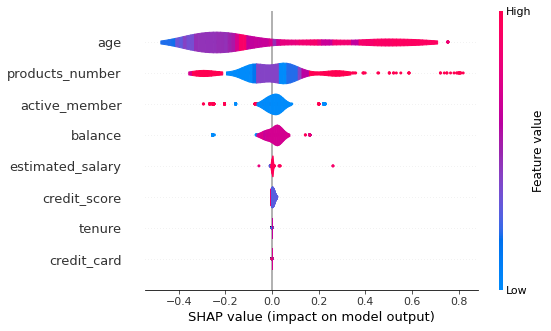

In [156]:
shap.summary_plot(shap_values, plot_type = 'violin')